# Training Quantum Machine Learning Models

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

import matplotlib 
matplotlib.rcParams['font.size'] = 14

# Qiskit imports
from qiskit import Aer, execute
from qiskit.algorithms.optimizers import GradientDescent, SPSA, QNSPSA
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZZFeatureMap
from qiskit.opflow import Z, I, StateFn, PauliExpectation, CircuitSampler
from qiskit.opflow import Gradient, NaturalGradient
from qiskit.quantum_info import Statevector
from qiskit.utils import QuantumInstance
from qiskit.visualization.bloch import Bloch

## Parametrized Quantum Circuits

Parameterized quantum circuits, where the gates are defined through tunable parameters, are a fundamental building block of near-term quantum machine learning algorithms. In the literature, depending on the context, parameterized quantum circuits are also called parameterized trial states, variational forms or ansatze.

Here is an example of a simple parameterized circuit, with two parameterized gates, a single-qubit $z$-rotation gate, with a variable rotation $\theta$, followed by a two-qubit controlled $z$-rotation gate, with the same variable rotation $\theta$: 

<figure>
  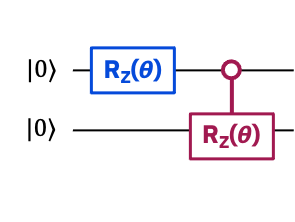
</figure> 

The parameterized circuit above can be created in Qiskit using the `QuantumCircuit`  and `Parameter` classes. This allows us to create a circuit with rotation gates, without having to specify what the angles are yet:

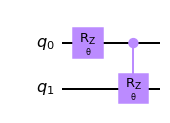

In [2]:
theta = Parameter('θ')

qc = QuantumCircuit(2)
qc.rz(theta,0)
qc.crz(theta,0,1)
qc.draw(output='mpl')

If we want the gates to have different parameters, we can use two `Parameters`, or we create a `ParameterVector`, which acts like a list of `Parameters`:

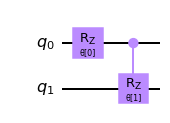

In [3]:
theta_list = ParameterVector('θ', length=2)

qc = QuantumCircuit(2)
qc.rz(theta_list[0],0)
qc.crz(theta_list[1],0,1)
qc.draw(output='mpl')

As all quantum gates used in a quantum circuit are unitary, a parametrized circuit itself can be described as a unitary operation on $n$ qubits, $\mathbf{U_\theta}$, acting on some initial state $|\phi_0\rangle$, often set to $|0\rangle^{\otimes n}$. The resulting parameterized quantum state is $|\psi_\mathbf{\theta}\rangle = \mathbf{U_\theta} |\phi_0\rangle$ where $\mathbf{\theta}$ is a set of tunable parameters.

<div class="alert alert-block alert-success">

**Exercise 1**

Create this parameterized quantum circuit:


<figure>
  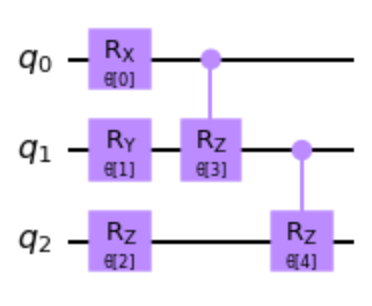
</figure> 

</div>

In [4]:
##############################
# your code here


##############################

### Parametrized Quantum Circuit Properties

How do we choose one parameterized circuit over the other? To use parameterized quantum circuits as a machine learning model, we need them to generalize well. This means that the selected circuit should be able to generate a significant subset of the states within the output Hilbert space. To avoid being easy to simulate on a classical computer, the selected circuit should ideally also entangle qubits. 

In [**_Sim et al._  Adv. Quantum Technol. 2 (2019) 1900070**](https://onlinelibrary.wiley.com/doi/abs/10.1002/qute.201900070), the authors propose the measures of *expressibility* and *entangling capability* to discriminate between different parameterized quantum circuits. The *expressibility* of a circuit can be understood as the extent to which a parametrized circuit is able to generate states within the Hilbert space, while the *entangling capability* of a circuit describes its ability to generate entangled states.

#### *Expressibility*

*Expressibility* of a parameterized quantum circuit is quantified in [**_Sim et al._  Adv. Quantum Technol. 2 (2019) 1900070**](https://onlinelibrary.wiley.com/doi/abs/10.1002/qute.201900070) by computing the extent to which the states generated from the circuit deviate from the uniform distribution. 

Let's compare the two following single-qubit circuits to get a sense of what it means for a circuit to be expressible or not, by sampling 2000 output states for each circuit and plotting them on a Bloch sphere. 

<figure>
  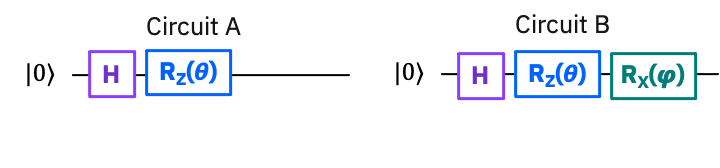
</figure> 

First, we need to define the circuits:

In [5]:
theta_param = Parameter('θ')
phi_param = Parameter('Φ')

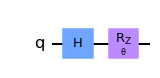

In [6]:
# Circuit A
qc_A = QuantumCircuit(1)
qc_A.h(0)
qc_A.rz(theta_param,0)
qc_A.draw(output='mpl')

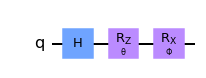

In [7]:
# Circuit B
qc_B=QuantumCircuit(1)
qc_B.h(0)
qc_B.rz(theta_param,0)
qc_B.rx(phi_param,0)
qc_B.draw(output='mpl')

Next we uniformly sample the parameter space for the two parameters $\theta$ and $\phi$:

In [8]:
np.random.seed(0)
num_param = 2000
theta = [2*np.pi*np.random.uniform() for i in range(num_param)]
phi = [2*np.pi*np.random.uniform() for i in range(num_param)]

Then we take the parameter value lists, build the state vectors corresponding to each circuit and plot them on the Bloch sphere:

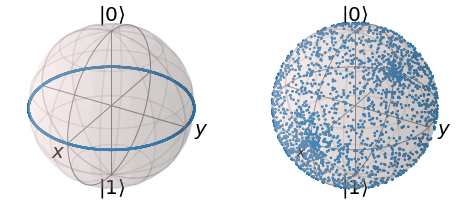

In [9]:
# Converts state vectors to points on the Bloch sphere
def state_to_bloch(state_vec):
    phi = np.angle(state_vec.data[1])-np.angle(state_vec.data[0])
    theta = 2*np.arccos(np.abs(state_vec.data[0]))
    return [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]

# Bloch sphere plot formatting
width, height = plt.figaspect(1/2)
fig=plt.figure(figsize=(width, height))
ax1, ax2 = fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')
b1,b2 = Bloch(axes=ax1), Bloch(axes=ax2)
b1.point_color, b2.point_color = ['tab:blue'],['tab:blue']
b1.point_marker, b2.point_marker= ['o'],['o']
b1.point_size, b2.point_size=[2],[2]

# Calculate state vectors for circuit A and circuit B for each set of sampled parameters
# and add to their respective Bloch sphere
for i in range(num_param):    
    state_1=Statevector.from_instruction(qc_A.bind_parameters({theta_param:theta[i]}))
    state_2=Statevector.from_instruction(qc_B.bind_parameters({theta_param:theta[i], phi_param:phi[i]}))
    b1.add_points(state_to_bloch(state_1))
    b2.add_points(state_to_bloch(state_2))

b1.show()
b2.show()

For Circuit A, with a Hadamard gate followed by a parameterized $z$-rotation gate, we observe output states distributed about the equator of the Bloch sphere (left). With Circuit B, with the additional parameterized $z$-rotation gate, we are able to cover all the Bloch sphere with output states, but the coverage is not uniform; there are concentrations of points on the $+X$ and $-X$ poles of the Bloch sphere.  

Expressibility is a way to quantify what we just observed for these single-qubit circuits. Circuit A would have a low expressibility score due to the limited set of states it can explore, whereas Circuit B would have a high expressibility score.  

#### *Entangling Capability*

Entanglement is often seen as a key resource in quantum computing. The Meyer-Wallach measure is one of many metrics that can be used quantify how entangled a given state is. The Meyer-Wallach measure of an unentangled product state is 0, while the Meyer-Wallach measure of a highly entangled state, such as the Bell state, is 1. In [**_Sim et al._  Adv. Quantum Technol. 2 (2019) 1900070**](https://onlinelibrary.wiley.com/doi/abs/10.1002/qute.201900070), the authors define the entangling capability of a parameterized quantum circuit as the average Meyer-Wallach measure for the states it can generate.

For example, consider the following multi-qubit parameterized circuits:
<figure>
  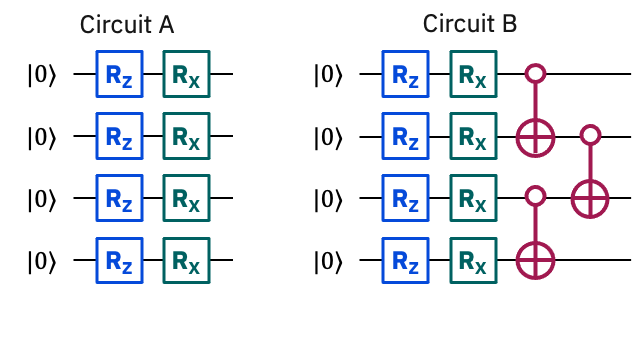
</figure> 

Circuit A has no entangling operations, that is, no two-qubit gates, so it has no entangling capability. Thus, this circuit would produce states that have Meyer-Wallach measures of 0, leading to an averaged value of 0. Circuit B has several two-qubit gates and thus is able to generate quantum states with some entanglement. Therefore, the average Meyer-Wallach measure would be greater than 0. 

Using these two parameterized quantum circuit descriptors, expressibility and entangling capability, we can identify circuits that have limited capabilities. We expect that limited circuits are poor candidates for quantum machine learning applications. 

#### *Hardware Efficiency*

In this era of near term quantum computing, where devices have limited qubit connectivity, coherence times and gate fidelities, the depth of the circuits we run directly affects the accuracy of our results, since there is limited error correction or mitigation.

A class of hardware efficient parameterized circuits was introduced in [**_Kandala et al._  Nature 549, 242–246 (2017)**](https://doi.org/10.1038/nature23879) to accommodate device constraints. The common trait of these circuits is the use of a limited set of quantum gates as well as a particular qubit connection topology. The gate set usually consists of one two-qubit entangling gate and up to three single-qubit gates. The circuit is then constructed from blocks of single-qubit gates and entangling gates, which are applied to multiple or all qubits in parallel. One sequence of a single-qubit and an entangling block is called a layer, and the parameterized circuit generally has multiple layers.

Circuit B depicted in the [**Entangling Capability**](#Entangling-Capability) section is an example of a single layer hardware efficient parameterized circuit.

## Parameterized Quantum Circuits in Machine Learning

In quantum machine learning, parameterized quantum circuits tend to be used for two things: to encode data, where the parameters are determined by the data being encoded, and as a quantum model, where the parameters are determined by an optimization process. 

Qiskit provides a set of commonly used [**data encoding**](https://qiskit.org/documentation/apidoc/circuit_library.html#data-encoding-circuits) and [**variational circuits**](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits) in the circuit library. 

### Variational Quantum Classifier

In fact, the  variational quantum classifier is just a combination of these. We want to build a quantum circuit whose output is a quantum state:
$$|\psi(x:\theta)\rangle = P(y=0| x; \theta)|0\rangle + P(y=1| x; \theta|1\rangle $$
where $x$ is the datapoint being encoded and $\theta$ are the parameters of the variational circuit.

We build this quantum state by designing a quantum circuit that behaves similarly to a traditional machine learning algorithm. The quantum machine learning algorithm contains a circuit which dpeneds on a set of parameters that, through training, we will optimize to reduce the value of a cost function.   

#### Classifier Circuit

There are multiple components to the classifier circuit: (1) data encoding (2) variational model (3) measurement:

<figure>
  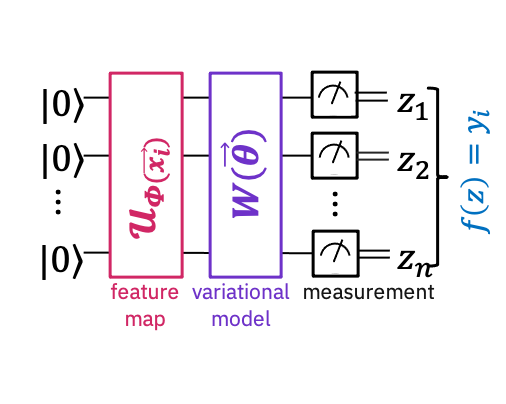
</figure> 

#### _Data Encoding_

Data representation is crucial for the success of machine learning models. For classical machine learning, this question usually takes the form how to represent the data numerically, so that it can be best processed by a classical machine learning algorithm. 

For quantum machine learning, this question is similar, but more fundamental: how to represent and efficiently input the data into a quantum system, so that it can be processed by a quantum machine learning algorithm. This is usually referred to as data *encoding*, but is also called data *embedding* or *loading*.

This process is a critical part of quantum machine learning algorithms and directly affects their computational power. This is an active area of research. 

There are various methods for data encoding, but the one generally used in the variational quantum classifier is arbitary encoding, which encodes $N$ features as rotations on $N$ parameterized gates on $n$ qubits, where $n \leq N$. It only encodes one datapoint at a time, rather than a whole dataset and uses a constant depth quantum circuit and $n \leq N$ qubits, meaning it can be run on current quantum hardware. 

For example, to use the Qiskit [**`EfficientSU2`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html) circuit to encode 12 features, would only use 3 qubits:

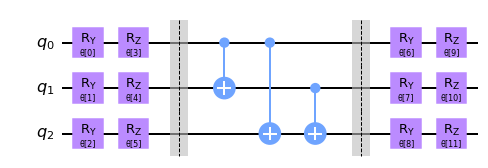

In [10]:
circuit = EfficientSU2(num_qubits=3, reps=1, insert_barriers=True)
circuit.decompose().draw(output='mpl')

Here we encode the datapoint $x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2]$ with 12 features, using each of the parameterized gates to encode a different feature.

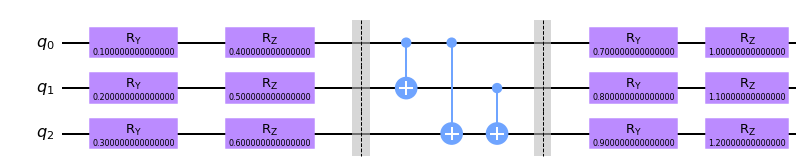

In [11]:
x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2]

encode = circuit.bind_parameters(x)
encode.decompose().draw(output='mpl')

The Qiskit [**`ZZFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) circuit with 3 qubits, only encodes a datapoint of 3 features, despite having 6 parameterized gates:

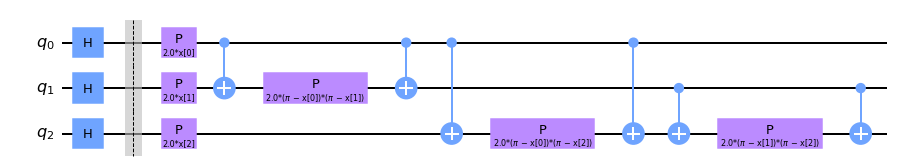

In [12]:
circuit = ZZFeatureMap(3, reps=1, insert_barriers=True)
circuit.decompose().draw(output='mpl')

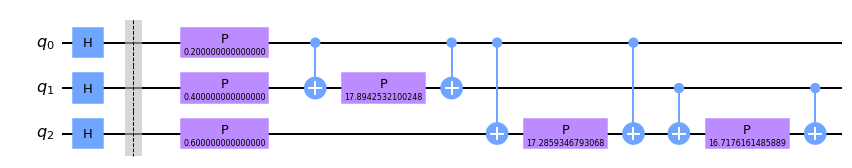

In [13]:
x = [0.1,0.2,0.3]

encode = circuit.bind_parameters(x)
encode.decompose().draw(output='mpl')

The choice of which parameterized quantum circuit to use to encode what data is an active area of investigation.

<div class="alert alert-block alert-success">

**Exercise 2**

Encode x = [0.1, 0.2, 0.3, 0.4] using the `ZZFeatureMap` and the `EfficientSU2` circuits.
    
</div>

In [14]:
##############################
# your code here


##############################

#### _Variational Model_

The next part of the classifier circuit is the variational model, or ansatz: a parameterized quantum circuit whose parameters are optimized by a training procedure. This is somewhat analogous to a neural network, where the circuit parameters are the weights that will be trained. Just as the architecture of a classical neural network is important for performance of the classical algorithm, the form of the variational circuit is important for the performance of the quantum algorithm. 

It is essential to choose a variational circuit that is shorter depth (hardware efficient), less parameters (faster training) while making sure it is expressive (covers more parameter space) and has high entangling capability (to make it more 'quantum' and less 'classical'). Building variational circuits with such conflicting properties, similar to the study on quantum feature maps, is an active field of research.

Qiskit has many different circuits in the [**library**](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits) that can be used as variation forms. For example, there's the [**`RealAmplitudes`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) circuit:

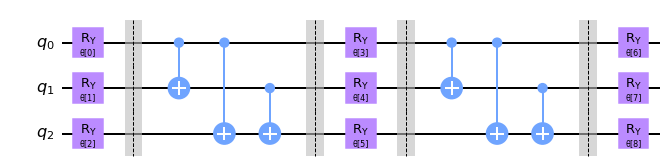

In [15]:
circuit = RealAmplitudes(num_qubits=3, reps=2, insert_barriers=True)
circuit.decompose().draw(output='mpl')

Or the more expressive [**`EfficientSU2`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html) circuit seen earlier:

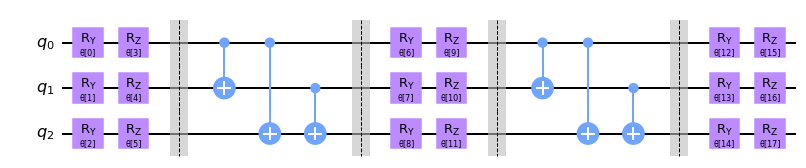

In [16]:
circuit = EfficientSU2(num_qubits=3, reps=2, insert_barriers=True)
circuit.decompose().draw(output='mpl')

The depth of these variational circuits can be increased to introduce more trainable parameters.

#### _Measurement_

An *n bit* classification string is obtained once we measure the classification circuit. This string is now assigned values of the classification classes. This is done using a boolean function $f: \{0, 1\}^{n} \rightarrow \{0, 1\}$. Common examples of boolean functions are:

- Parity function : modulus 2 sum of all the digits of the *n bit* classical string.
- Choosing the $k^{th}$ digit : Choose the digit number $k$ in the *n bit* classical string as the output.

#### Variational Quantum Classifier Implementation

Let's implement all the separate components of the variational quantum classifer, and classify a very simple dataset. Note that the following code requires the class labels be in $\{0,1\}$.

1. We create a very simple two-dimensional classification dataset.

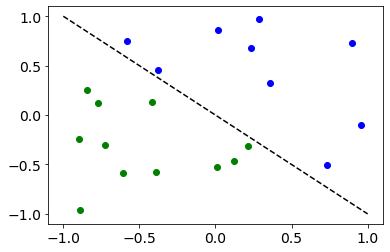

In [17]:
num_inputs = 2
num_samples = 20
X = 2*np.random.rand(num_samples, num_inputs) - 1
y = 1*(np.sum(X, axis=1) >= 0)
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

2. We prepare the classification circuit, using the Qiskit `ZZFeatureMap` as the data encoding circuit, and the Qiskit `RealAmplitudes` circuit as the variational circuit.

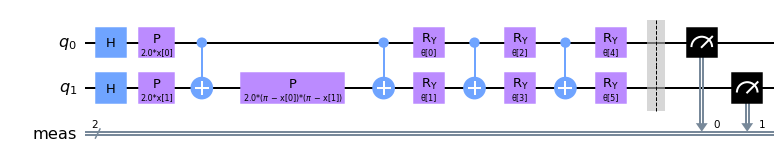

In [18]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=1)
var_form = RealAmplitudes(num_qubits=2, reps=2)

classify_circuit = feature_map.compose(var_form)
classify_circuit.measure_all()
classify_circuit.decompose().draw(output="mpl")

3. We create a function that associates the data to the feature map and the variational parameters to the variational circuit. This is to ensure that the right parameters in the circuit are associated with the right quantities.

In [19]:
def circuit_parameters(data, variational):
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = variational[i]
    return parameters

4. We create a class assignment function to calculate the parity of the given bitstring. If the parity is even, it returns a $1$ label, and if the parity is odd it returns a $0$ label.

In [20]:
def assign_label(bitstring):
    hamming_weight = sum([int(k) for k in list(bitstring)])
    odd = hamming_weight & 1
    if odd:
        return 0
    else:
        return 1

5. We create a function the returns the probability distribution over the label classes, given experimental counts from running the quantum circuit multiple times.

In [21]:
def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = assign_label(bitstring)
        probabilities[label] += counts / shots
    return probabilities

6. We create a function that classifies our data. It takes in data and parameters. For every data point in the dataset, we assign the parameters to the feature map and the parameters to the variational circuit. We then evolve our system and store the quantum circuit, so as to run the circuits at once at the end. We measure each circuit and return the probabilities based on the bit string and class labels.

In [22]:
def classification_probability(data, variational):
    circuits = [classify_circuit.assign_parameters(circuit_parameters(d,variational)) for d in data]
    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    classification = [label_probability(results.get_counts(c)) for c in circuits]
    return classification

6. For training, we create the loss and cost functions.

In [23]:
def cross_entropy_loss(predictions, expected):
    p = predictions.get(expected)
    return -(expected*np.log(p)+(1-expected)*np.log(1-p))
   
def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)
    
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)

    return cost

7. We set up our classical optimizer, using [`SPSA`](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html), initialize our variational circuit parameters and optimize our cost function modifying the variational circuit parameters, using our 40 training datapoints. Note that the optimization will take a while to run. 

In [24]:
# Callback function for optimiser for plotting purposes
def store_intermediate_result(evaluation, parameter, cost, stepsize, accept):
    evaluations.append(evaluation)
    parameters.append(parameter)
    costs.append(cost)

In [25]:
# Set up the optimization
from qiskit.algorithms.optimizers import SPSA

parameters = []
costs = []
evaluations = []

optimizer = SPSA(maxiter=100, callback=store_intermediate_result)

initial_point = np.random.random(var_form.num_parameters)
initial_point
#initial_point = np.array([0.60467427, 0.56192098, 0.71257587, 
#                          0.34970934, 0.55745783, 0.420224  ])

objective_function = lambda variational: cost_function(X, y, variational)

In [26]:
# Run the optimization
opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

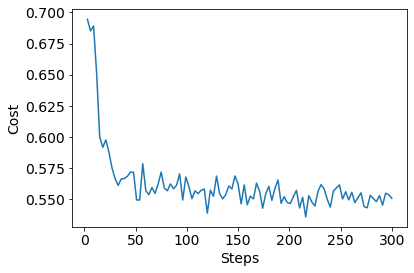

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

Plotting the cost function with respect to optimization step, we can see it converge to a minimum.

8. We implement a function to score our variational quantum classifier, using the classification function we created earlier, and use it to test our trained classifer on our  datapoints.

In [28]:
def score_classifier(data, labels, variational):
    probability = classification_probability(data, variational)

    prediction = [0 if p[0] >= p[1] else 1 for p in probability]
    
    accuracy = 0
    for i, p in enumerate(probability):
        if (p[0] >= p[1]) and (labels[i] == 0):
            accuracy += 1
        elif (p[1]) >= p[0] and (labels[i] == 1):
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [29]:
accuracy, prediction = score_classifier(X, y, opt_var)
accuracy

0.25

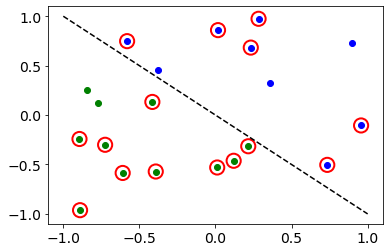

In [30]:
# evaluate data points

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, prediction):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

We see that the performance of the trained classifier is not great on the data. The training optimization probably found a local minimum, rather than the global minimum.

See this [**Qiskit tutorial**](https://qiskit.org/documentation/machine-learning/tutorials/02_neural_network_classifier_and_regressor.html) for different ways of building a variational quantum classifier using Qiskit. 

## Training Parameterized Quantum Circuits

Like classical models, as we have just seen, we can train parameterized quantum circuit models to perform data-driven tasks. The task of learning an arbitrary function from data is mathematically expressed as the minimization of a cost or loss function $f(\vec\theta)$, also known as the
objective function, with respect to the parameter vector $\vec\theta$. Generally, when training a parameterized quantum circuit model, the function we are trying to minimise is the expectation value: $\langle \Psi(\vec\theta) | \hat{H}| \Psi(\vec\theta) \rangle$.

<br/>
<figure>
  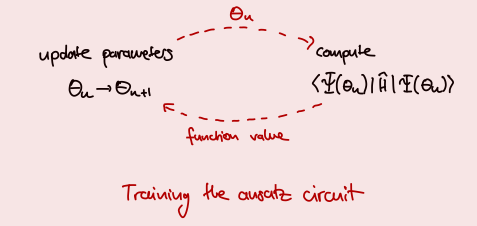
</figure> 

There are many different types of algorithms that we can use to optimise the parameters of a variational circuit, $\mathbf{U_\theta}$: for example, gradient-based, gradient-free methods and evolutionary; we will be discussing gradient-based methods. 

### Gradients

If we have a function $f(\vec\theta)$, and we have access to the gradient of the function, $\vec\nabla f(\vec\theta)$, starting from an initial point, then the simplest way to minimize the function is to update the parameters towards the direction of steepest descent of the function: $\vec\theta_{n+1} = \vec\theta_n - \eta\vec\nabla f(\vec\theta)$, where $\eta$ is the learning rate - a small, positive hyperparameter controlling the size of the update. We continue doing this until we converge to a local minimum of the function, $f(\vec\theta^*)$.

<figure>
  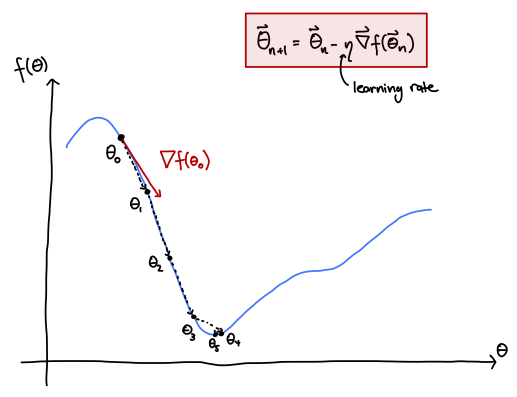
</figure>

This technique is called **gradient descent** or **vanilla gradient descent**, since it's the plain gradient, we aren't doing anything special to it. 

Qiskit provides different methods to compute gradients of expectation values, let's explore them!

First we need to define our parameterized state, $|\Psi(\vec\theta)\rangle = U(\vec\theta)|0\rangle$ where $U(\vec\theta)$ can be any parameterized circuit, for instance, the Qiskit [**`RealAmplitudes`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) circuit:

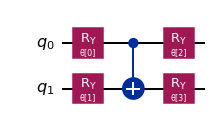

In [31]:
ansatz = RealAmplitudes(num_qubits=2, reps=1, entanglement='linear').decompose()
ansatz.draw('mpl', style='iqx')

Next we need to define a Hamiltonian, let's use: $\hat H = \hat Z \bigotimes \hat Z$

In [32]:
hamiltonian = Z ^ Z

Putting them together to make the expectation value: $\langle \Psi(\vec\theta) | \hat{H}| \Psi(\vec\theta) \rangle$

In [33]:
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)

Next we write a function to simulate the measurement of the expectation value, note that we set `seed_simulator = 2718` and `seed_transpiler = 2718` just for reproducibility:

In [34]:
quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), shots = 8192, seed_simulator = 2718, seed_transpiler = 2718)
sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(pauli_basis, params=value_dict).eval()  
    return np.real(result)

To make things concrete, let's fix a point $\vec p$ and an index $i$ and ask: What's the derivative of the expectation value with respect to parameter $\theta_i$ at point $\vec p$?

$$
    \frac{\partial}{\partial \theta_i} \langle \Psi(\vec\theta) | \hat H | \Psi(\vec\theta) \rangle \bigg\vert_{\vec\theta = \vec p}
$$

We'll choose a random point $\vec p$ and index $i=2$ (remember we start counting from 0).

In [35]:
point = np.random.random(ansatz.num_parameters)
index = 2

#### Finite difference gradients

Arguably the simplest way to approximate gradients is with a finite difference scheme. This works independently of the function's inner, possibly very complex, structure.

<figure>
  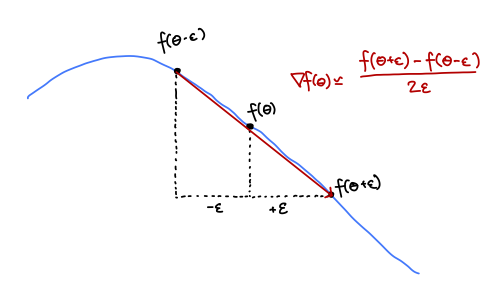
</figure>

If we are interested in estimating the gradient at $f(\vec\theta)$, we can choose some small distance $\epsilon$ and calculate $f(\vec\theta+\epsilon\vec e_i)$ and $f(\vec\theta-\epsilon\vec e_i)$ where $e_i$ is the unit vector in dimension $i$; then take the difference between the two function values, divided by the distance: $\vec\nabla f(\vec\theta) \approx \frac{1}{2\epsilon}\left(f(\vec\theta+\epsilon\vec e_i) - f(\vec\theta-\epsilon\vec e_i) \right)$.

In [36]:
eps = 0.2
e_i = np.identity(point.size)[:, index]  # identity vector with a 1 at index ``index``, otherwise 0

plus = point + eps * e_i
minus = point - eps * e_i

In [37]:
finite_difference = (evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * eps)
print(finite_difference)

0.010375976562500139


Instead of doing this manually, we can use Qiskit's [**`Gradient`**](https://qiskit.org/documentation/stubs/qiskit.aqua.operators.gradients.Gradient.html) class for this.

In [38]:
shifter = Gradient('fin_diff', analytic=False, epsilon=eps)
grad = shifter.convert(expectation, params=ansatz.parameters[index])
print(grad)

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])


In [39]:
value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, value_dict).eval().real

-0.020141601562500222

Finite difference gradients can be volatile on noisy functions and using the exact formula for the gradient can be more stable. More instance, in the example below, the noisy finite difference gradient calculated is not just a little bit wrong - it even points in the wrong direction!

<figure>
  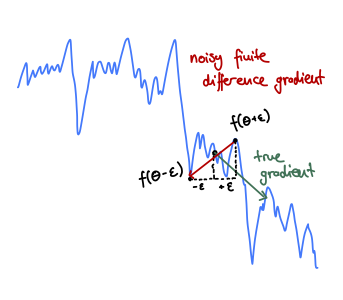
</figure>


#### Analytic gradients

Analytics gradients evaluate the analytic formula for the gradients. In general, that is fairly difficult, because we have to do a manual calculation, but for circuit based gradients, there's a very nice theoretical result that gives us a very easy formula for calculating gradients - the _parameter shift_ rule first introduced in [**_Schuld et al._ Phys. Rev. A 99, 032331 (2019)**](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.99.032331).

For a simple circuit consisting of only Pauli rotations, without any coefficients, then this rule says that the analytic gradient is:
<figure>
  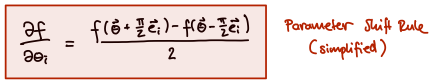
</figure>

which is very similar to the equation for finite difference gradients. 

Let's try calculate it by hand:

In [40]:
eps = np.pi / 2
e_i = np.identity(point.size)[:, index]

plus = point + eps * e_i
minus = point - eps * e_i

finite_difference = (evaluate_expectation(plus) - evaluate_expectation(minus)) / 2

print(finite_difference)

0.005004882812499972


And using the Qiskit Gradient class:

In [41]:
shifter = Gradient()  # parameter-shift rule is the default
grad = shifter.convert(expectation, params=ansatz.parameters[index])
sampler.convert(grad, value_dict).eval().real

0.0064697265625

We see that the calculated analytic gradient is fairly similar to the calculated finite difference gradient. They are not exactly the same due to shot noise. 

Now that we know to calculate gradients, let's try optimizing the expectation value!

First we fix an initial point for reproducibility.

In [42]:
# initial_point = np.random.random(ansatz.num_parameters)
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

Similar to how we had a function to evaluate the expectation value, we'll need a function to evaluate the gradient.

In [43]:
gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(quantum_instance)

def evaluate_gradient(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(gradient_in_pauli_basis, params=value_dict).eval()
    return np.real(result)    

To compare the convergence of the optimizers, we can keep track of the loss at each step by using a callback function.

<figure>
  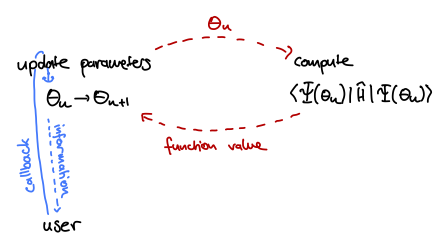
</figure>


In [44]:
gd_loss = []
def gd_callback(nfevs, x, fx, stepsize):
    gd_loss.append(fx)
    
gd = GradientDescent(maxiter=300, learning_rate=0.01, callback=gd_callback)

And now we start the optimization and plot the loss!

In [45]:
x_opt, fx_opt, nfevs = gd.optimize(initial_point.size,    # number of parameters
                                   evaluate_expectation,  # function to minimize
                                   gradient_function=evaluate_gradient,  # function to evaluate the gradient
                                   initial_point=initial_point)  # initial point

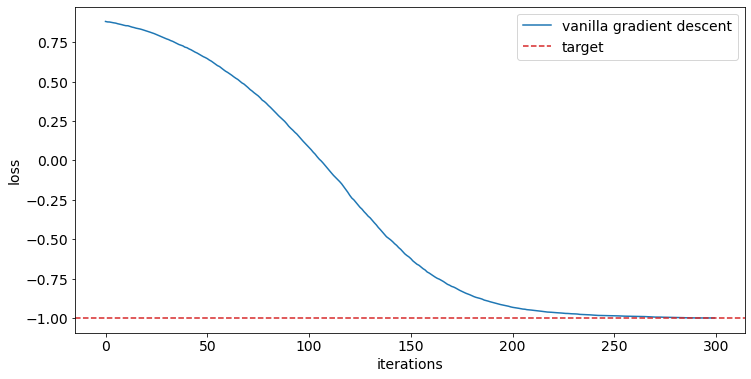

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(gd_loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='tab:red', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

#### Natural gradients

We see in the above example that we are able to find the minimum of the function using gradient descent. However this is not always the case.

<figure>
  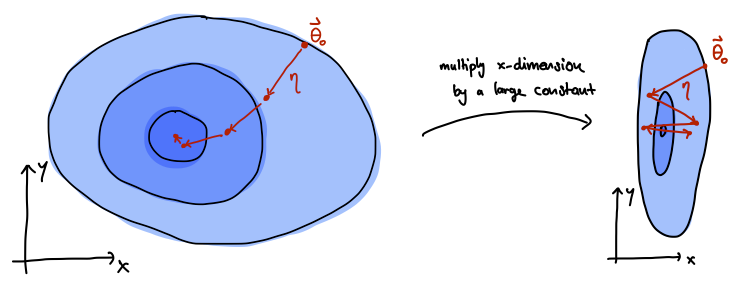
</figure>

For example, if we look at the diagram on the left, given the initial point on the edge of the loss landscape, $\theta_0 = (x_0,y_0)$ and learning rate $\eta$, we are able to approach the minimum in the centre. However, looking at the diagram on the right, where the loss landscape has been squashed in the $x$-dimension, we see that using the same initial point and learning rate, we are unable to find the minimum, as we are not taking into account that the loss landscape might vary at a different rate with respect to each parameter.  

The idea of natural gradients is to change the way we determine $\theta_{n+1}$ from $\theta_n$ by considering the sensitivity of the model. In vanilla gradients, we used the Euclidean distance between them: $d = ||\vec\theta_{n+1}-\vec\theta_n||_2$, but we saw that this doesn't take the loss landscape into account. For instance, in the image below, both Model A and Model B show the same euclidean distance of the two points, but since B is more sensitive than A we don't want to assign the same distance to them. We want to take smaller steps in x-direction in B than in A, but the euclidean metric doesn't capture this. Instead in natural gradients, we use a distance that is dependent on our model: $d = \left|\langle \Psi(\vec\theta_n)|\Psi(\vec\theta_{n+1}) \rangle\right|^2$.

<figure>
  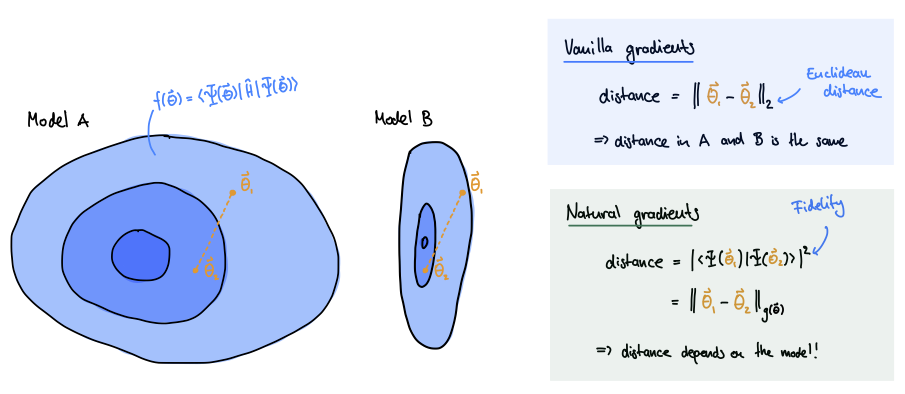
</figure>

<figure>
  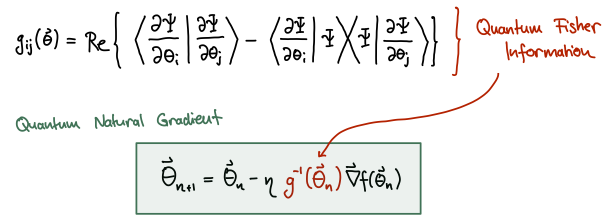
</figure>

This metric is called the **Quantum Fisher Information**, $g_{ij}(\vec\theta)$, and allows us to transform the steepest descent in the Euclidean parameter space to the steepest descent in the model space, in what is called **Quantum Natural Gradient**, introduced in [**_Stokes et al_ Quantum 4, 269 (2020)**](https://quantum-journal.org/papers/q-2020-05-25-269/), where $\vec\theta_{n+1} = \vec\theta_n-\eta g^{-1}(\vec\theta_n)\vec\nabla f(\theta_n)$.

<figure>
  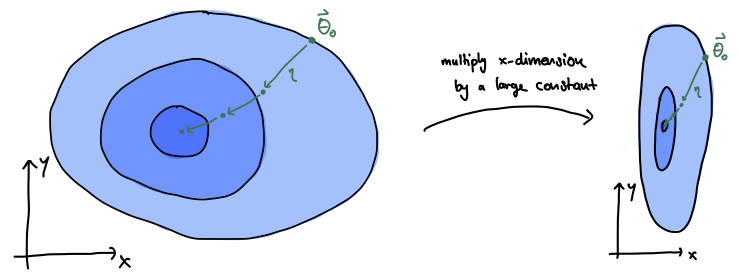
</figure>


To evaluate the natural gradient in Qiskit, it is very simple, we just use the [**`NaturalGradient`**](https://qiskit.org/documentation/stubs/qiskit.aqua.operators.gradients.NaturalGradient.html) instead of the [**`Gradient`**](https://qiskit.org/documentation/stubs/qiskit.aqua.operators.gradients.Gradient.html)!

Analogous to the function to compute gradients, we can now write a function to evaluate the natural gradients.

In [47]:
natural_gradient = NaturalGradient(regularization='ridge').convert(expectation)
natural_gradient_in_pauli_basis = PauliExpectation().convert(natural_gradient)
sampler = CircuitSampler(quantum_instance, caching="all")

def evaluate_natural_gradient(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(natural_gradient, params=value_dict).eval()  
    return np.real(result)    

And as you can see they do indeed differ!

In [48]:
print('Vanilla gradient:', evaluate_gradient(initial_point))
print('Natural gradient:', evaluate_natural_gradient(initial_point))

Vanilla gradient: [ 0.13989258 -0.35095215 -0.25402832 -0.22497559]
Natural gradient: [ 0.7158704  -0.86457346 -0.98086467 -0.33820315]


Let's look at how this influences the convergence.

In [49]:
qng_loss = []
def qng_callback(nfevs, x, fx, stepsize):
    qng_loss.append(fx)
    
qng = GradientDescent(maxiter=300, learning_rate=0.01, callback=qng_callback)

In [50]:
x_opt, fx_opt, nfevs = qng.optimize(initial_point.size, 
                                    evaluate_expectation, 
                                    gradient_function=evaluate_natural_gradient,
                                    initial_point=initial_point)

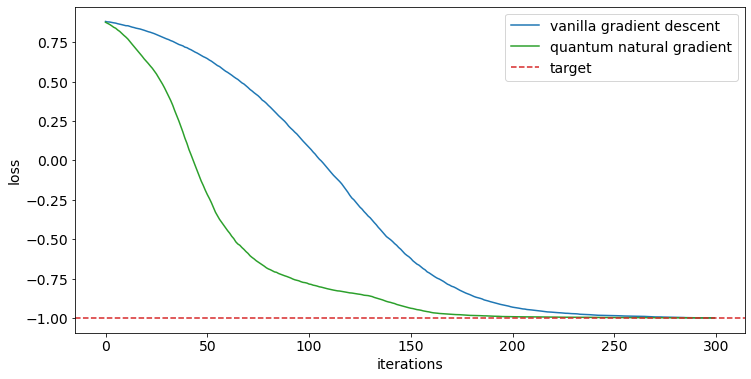

In [51]:
def plot_loss():
    plt.figure(figsize=(12, 6))
    plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
    plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
    plt.axhline(-1, c='tab:red', ls='--', label='target')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    
plot_loss()

This looks great! We can see that the quantum natural gradient approaches the target faster than vanilla gradient descent. However, this comes at the cost of needing to evaluate many many more quantum circuits.

<br/>
<figure>
  
</figure>

#### Simultaneous Perturbation Stochastic Approximation

Looking at our function $f(\vec\theta)$ as a vector, if we want to evaluate the gradient $\vec\nabla f(\vec\theta)$, we need to calculate the partial derivation of $f(\vec\theta)$ with respect to each parameter, meaning we would need $2N$ function evaluations for $N$ parameters to calculate the gradient.

<figure>
  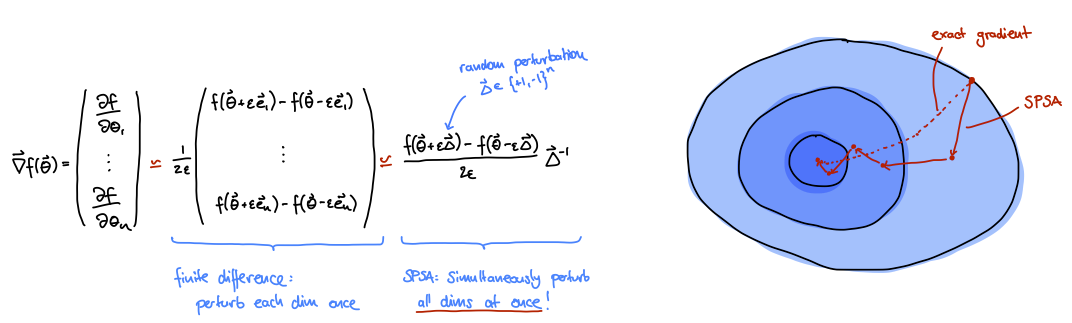
</figure>

Simultaneous Perturbation Stochastic Approximation or SPSA is an optimization technique where we randomly sample from the gradient, to reduce the number of evaluations. Since we don't care about the exact values but only about convergence, an unbiased sampling should on average work equally well.

In practise, while the exact gradient follows a smooth path to the minimum, SPSA will jump around due to the random sampling, but it will converge, given the same boundary conditions as the gradient. 

And how does it perform? We use the [**`SPSA`**](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html) algorithm in Qiskit. 

In [52]:
spsa_loss = []
def spsa_callback(nfev, x, fx, stepsize, accepted):
    spsa_loss.append(fx)

spsa = SPSA(maxiter=300, learning_rate=0.01, perturbation=0.01, callback=spsa_callback)

x_opt, fx_opt, nfevs = spsa.optimize(initial_point.size, 
                                     evaluate_expectation, 
                                     initial_point=initial_point)

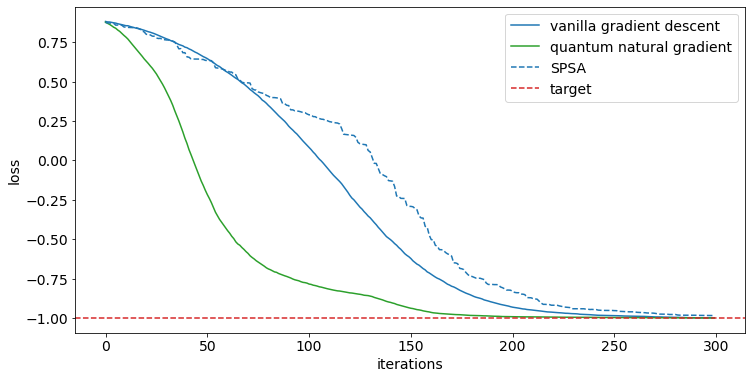

In [53]:
def plot_loss():
    plt.figure(figsize=(12, 6))
    plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
    plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
    plt.plot(spsa_loss, 'tab:blue', ls='--', label='SPSA')
    plt.axhline(-1, c='tab:red', ls='--', label='target')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    
plot_loss()

We can see that SPSA basically follows the gradient descent curve, _and_ at a fraction of the cost!

We can do the same for natural gradients as well, as described in [**_Gacon et al._ Quantum 5, 567 (2021)**](https://quantum-journal.org/papers/q-2021-10-20-567/). We'll skip the details here, but the idea is to sample not only from the gradient but to extend this to the quantum Fisher information and thus to the natural gradient.

Qiskit implements this as the [**`QNSPSA`**](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.QNSPSA.html) algorithm. Let's compare its performance:

In [54]:
qnspsa_loss = []
def qnspsa_callback(nfev, x, fx, stepsize, accepted):
    qnspsa_loss.append(fx)

fidelity = QNSPSA.get_fidelity(ansatz, quantum_instance, expectation=PauliExpectation())
qnspsa = QNSPSA(fidelity, maxiter=300, learning_rate=0.01, perturbation=0.01, callback=qnspsa_callback)

x_opt, fx_opt, nfevs = qnspsa.optimize(initial_point.size, 
                                       evaluate_expectation, 
                                       initial_point=initial_point)

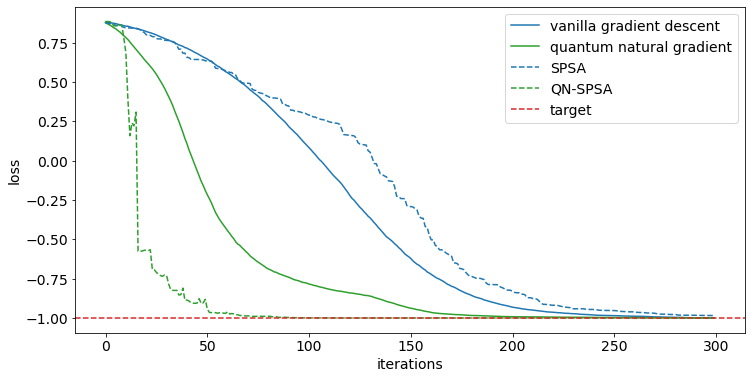

In [55]:
def plot_loss():
    plt.figure(figsize=(12, 6))
    plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
    plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
    plt.plot(spsa_loss, 'tab:blue', ls='--', label='SPSA')
    plt.plot(qnspsa_loss, 'tab:green', ls='--', label='QN-SPSA')
    plt.axhline(-1, c='tab:red', ls='--', label='target')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    
plot_loss()

We can see that QNSPSA somewhat follows the natural gradient descent curve. 

<br/>
<figure>
  
</figure>

If we compare the costs, we can see that the vanilla and natural gradients are linear and quadratic in terms of the number of parameters, while the costs for SPSA and QNSPSA are constant, they are independent of the number of parameters. There is the small offset between the costs for SPSA and QNSPSA as more evaluations are required to approximate the natural gradient. 

### Training in practice

In this era of near-term quantum computing, circuit evaulations are expensive and readouts are not perfect due to the noisy nature of the devices. Therefore in practice, people often resort to using SPSA. To improve convergence, we do however not use a constant learning rate, but an exponentially decreasing one (solid lines). The typical convergence between a constant learning rate (dotted lines) versus an exponentially decreasing one (solid lines) are shown below. We see that the convergence for a constant learning rate is smooth decreasing line, while the convergence for an exponentially decreasing one is steeper and more staggered. This works well is you know what your loss function looks like. 

<figure>
  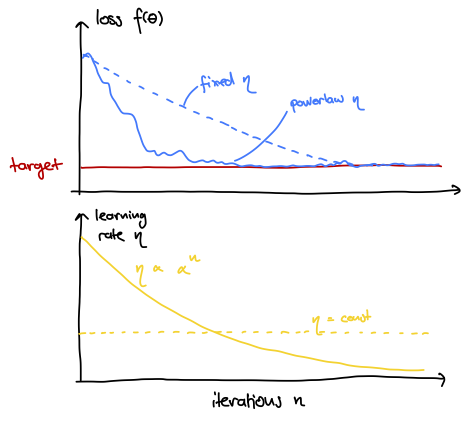
</figure>

Qiskit will try to automatically calibrate the learning rate to the model if you don't specify the learning rate.

In [56]:
autospsa_loss = []
def autospsa_callback(nfev, x, fx, stepsize, accepted):
    autospsa_loss.append(fx)

autospsa = SPSA(maxiter=300, learning_rate=None, perturbation=None, callback=autospsa_callback)

x_opt, fx_opt, nfevs = autospsa.optimize(initial_point.size, 
                                         evaluate_expectation, 
                                         initial_point=initial_point)

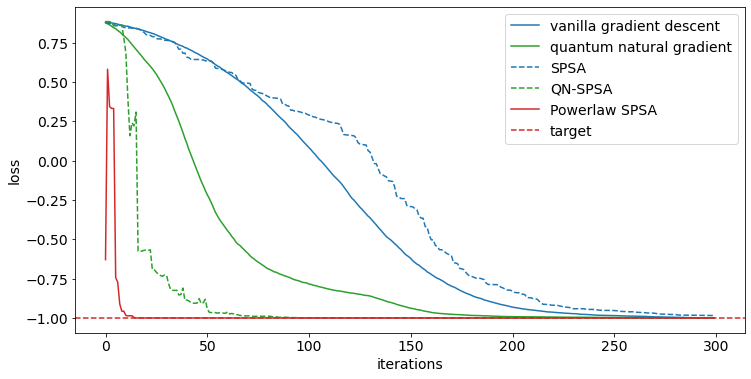

In [57]:
def plot_loss():
    plt.figure(figsize=(12, 6))
    plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
    plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
    plt.plot(spsa_loss, 'tab:blue', ls='--', label='SPSA')
    plt.plot(qnspsa_loss, 'tab:green', ls='--', label='QN-SPSA')
    plt.plot(autospsa_loss, 'tab:red', label='Powerlaw SPSA')
    plt.axhline(-1, c='tab:red', ls='--', label='target')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    
plot_loss()

We see here that it works the best of all the methods for this small model. For larger models, the convergence will probably be more like the natural gradient. 

## Limitations

We've seen that training with gradients works well on the small example model. But can we expect the same if we increase the number of qubits? To investigate that, we measure the variance of the gradients for different model sizes. The idea is simple: if the variance is really small, we don't have enough information to update our parameters.

### Exponentially vanishing gradients (barren plateaus)

Let's pick a standard parameterized quantum circuit ([**`RealAmplitudes`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html)) and see what happens if we increase the number of qubits and layers, that is increase the width and depth of thee circuit) as we calculate the gradient.

<figure>
  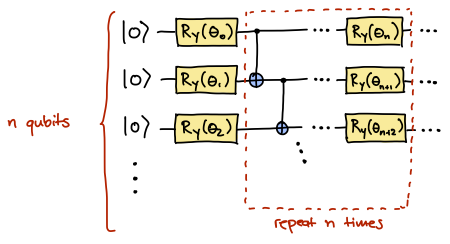
</figure>

In [58]:
def sample_gradients(num_qubits, reps, local=False):
    """Sample the gradient of our model for ``num_qubits`` qubits and ``reps`` repetitions.
    
    We sample 100 times for random parameters and compute the gradient of the first RY rotation gate.
    """
    index = num_qubits - 1

    # local or global operator
    if local:
        operator = Z ^ Z ^ (I ^ (num_qubits - 2))
    else:
        operator = Z ^ num_qubits
    
    # real amplitudes ansatz
    ansatz = RealAmplitudes(num_qubits, entanglement='linear', reps=reps)

    # construct Gradient we want to evaluate for different values
    expectation = StateFn(operator, is_measurement=True).compose(StateFn(ansatz))
    grad = Gradient().convert(expectation, params=ansatz.parameters[index])
    
    # evaluate for 100 different, random parameter values
    num_points = 100
    grads = []
    for _ in range(num_points):
        # points are uniformly chosen from [0, pi]
        point = np.random.uniform(0, np.pi, ansatz.num_parameters)
        value_dict = dict(zip(ansatz.parameters, point))
        grads.append(sampler.convert(grad, value_dict).eval())
        
    return grads

Let's run and plot from 2 to 12 qubits.

In [59]:
num_qubits = list(range(2, 13))
reps = num_qubits  # number of layers = numbers of qubits
gradients = [sample_gradients(n, r) for n, r in zip(num_qubits, reps)]  

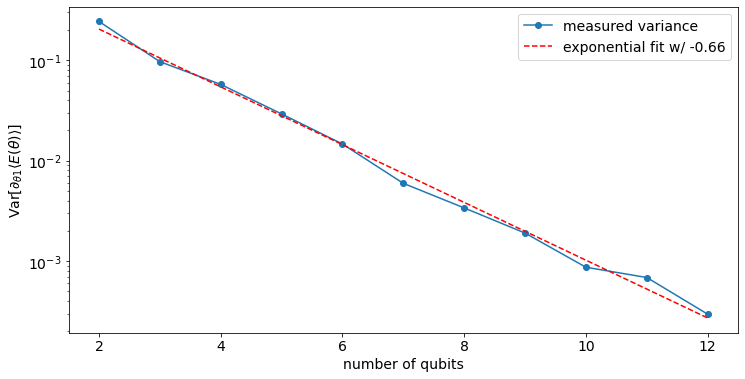

In [60]:
fit = np.polyfit(num_qubits, np.log(np.var(gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='measured variance')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

Oh no! The variance decreases exponentially! This means our gradients contain less and less information and we'll have a hard time to train the model. This is known as the **barren plateau problem** or **exponentially vanishing gradients**, discussed in detail in [**_McClean et al._ Nat Commun 9, 4812 (2018)**](https://www.nature.com/articles/s41467-018-07090-4) and [**_Cerezo et al._ Nat Commun 12, 1791 (2021)**](https://www.nature.com/articles/s41467-021-21728-w). 

Is there something we can do about these barren plateaus? It's a hot topic in current research and there are some proposals to mitigate barren plateaus.

Let's have a look at how global and local cost functions and the depth of the ansatz influences the barren plateaus. First, we look at short depth, single layer circuits with global operators. 

In [61]:
num_qubits = list(range(2, 13))
fixed_depth_global_gradients = [sample_gradients(n, 1) for n in num_qubits]  

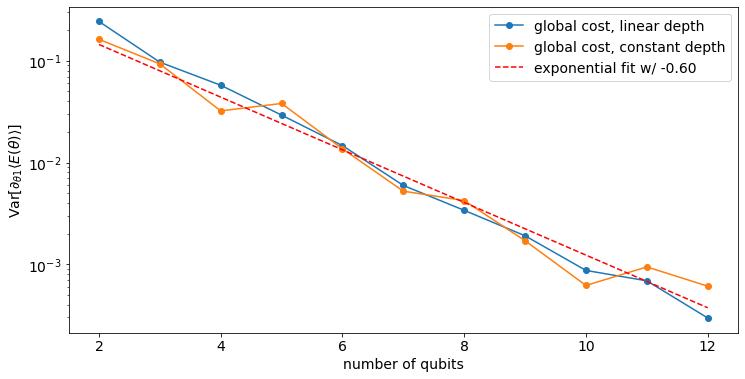

In [62]:
fit = np.polyfit(num_qubits, np.log(np.var(fixed_depth_global_gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1), 'o-', label='global cost, constant depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

We see that short depth, single layer circuits with global operators still give us barren plateaus. 

What if we use local operators?

In [63]:
num_qubits = list(range(2, 13))
linear_depth_local_gradients = [sample_gradients(n, n, local=True) for n in num_qubits]  

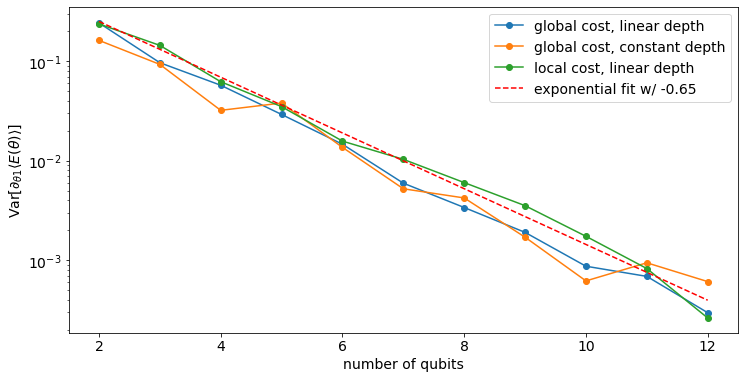

In [64]:
fit = np.polyfit(num_qubits, np.log(np.var(linear_depth_local_gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1), 'o-', label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1), 'o-', label='local cost, linear depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

We see that circuits with local operators still give us barren plateaus. 

How about short depth, single layer, circuits with local operators?

In [65]:
num_qubits = list(range(2, 13))
fixed_depth_local_gradients = [sample_gradients(n, 1, local=True) for n in num_qubits]  

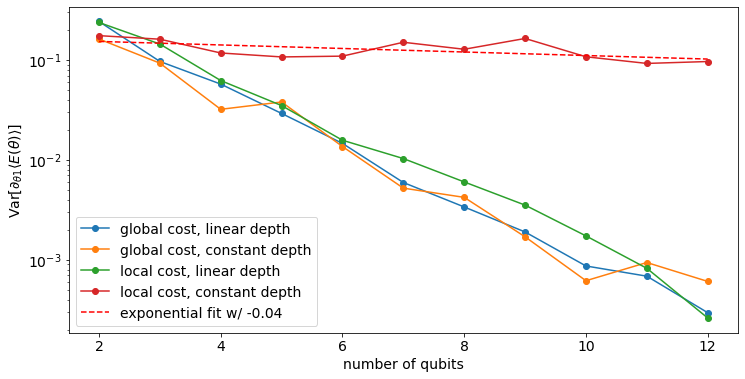

In [66]:
fit = np.polyfit(num_qubits, np.log(np.var(fixed_depth_local_gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1), 'o-', label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1), 'o-', label='local cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_local_gradients, axis=1), 'o-', label='local cost, constant depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

We see that the variance of the local operator, constant depth circuit gradients don't vanish, that is, we don't get barren plateaus. However, these circuits are usually easy to simulate and hence these models won't provide any advantage over classical models. 

This is the inspiration for layerwise training, where we start with a basic circuit that may not provide any quantum advantage, with one layer of rotations using local operators. We optimize and fix these parameters, then in the next step, we had a second layer of rotations using local operators, and optimize and fix those, and continue for however many layers we want. This potentially avoids barren plateaus as each optimization step is only using constant depth circuits with local operators. 

<figure>
  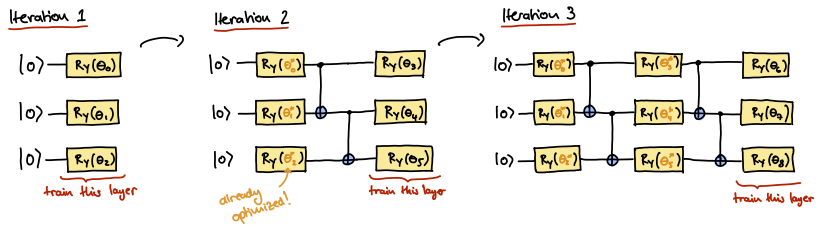
</figure>

We can implement this in Qiskit in the following way:

In [67]:
num_qubits = 6
operator = Z ^ Z ^ (I ^ (num_qubits - 4))

def minimize(circuit, optimizer):
    initial_point = np.random.random(circuit.num_parameters)
    
    exp = StateFn(operator, is_measurement=True) @ StateFn(circuit)
    grad = Gradient().convert(exp)
    
    exp = PauliExpectation().convert(exp)
    grad = PauliExpectation().convert(grad)

    sampler = CircuitSampler(quantum_instance, caching="all")
    
    def loss(x):
        values_dict = dict(zip(circuit.parameters, x))
        return np.real(sampler.convert(exp, values_dict).eval())
    
    def gradient(x):
        values_dict = dict(zip(circuit.parameters, x))
        return np.real(sampler.convert(grad, values_dict).eval())

    return optimizer.optimize(circuit.num_parameters, loss, gradient, initial_point=initial_point)

In [68]:
def layerwise_training(ansatz, max_num_layers, optimizer):
    optimal_parameters = []
    fopt = None
    for reps in range(1, max_num_layers):
        ansatz.reps = reps
        
        # fix the already optimized parameters
        values_dict = dict(zip(ansatz.parameters, optimal_parameters))
        
        # mark parameters that need to be optimized
        partially_bound = ansatz.bind_parameters(values_dict)
        
        xopt, fopt, _ = minimize(partially_bound, optimizer)
        print('Layer:', reps, ' Best Value:', fopt)
        optimal_parameters += list(xopt)
    
    return fopt, optimal_parameters

In [69]:
ansatz = RealAmplitudes(4, entanglement='linear')
optimizer = GradientDescent(maxiter=50)

In [70]:
np.random.seed(12)
fopt, optimal_parameters = layerwise_training(ansatz, 4, optimizer)

Layer: 1  Best Value: 0.2421875
Layer: 2  Best Value: -0.14428710937499992
Layer: 3  Best Value: -0.513427734375


We see that as we increase the circuit depth, our loss function decreases towards -1, so we don't see any barren plateaus. 